In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
file_path = "/content/drive/MyDrive/portugal_life_table.txt"

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

file_path = Path("/content/drive/MyDrive/portugal_life_table.txt")
assert file_path.exists(), " The HMD text file can’t be found — check the path."
print("  File found:", file_path)

  File found: /content/drive/MyDrive/portugal_life_table.txt


In [4]:
# Detect header line
with open(file_path) as f:
    header_line = 0
    for i, line in enumerate(f):
        if line.lower().startswith("year"):
            header_line = i
            break
print("Header is on line", header_line)

# Read the table from that header onward
df = pd.read_csv(
        file_path,
        sep=r"\s+",
        skiprows=header_line,
        na_values=".",
    )
print(df.head())
print("Columns:", df.columns.tolist())

Header is on line 0
  Portugal, Life   tables  (period 1x1),   Total   Last modified:       12  \
0      Year  Age       mx       qx    ax      lx     dx        Lx       Tx   
1      1940    0  0.14504  0.13177  0.31  100000  13177     90855  5138016   
2      1940    1  0.04956  0.04836  0.50   86823   4199     84723  5047161   
3      1940    2  0.01983  0.01964  0.50   82624   1623     81812  4962438   
4      1940    3  0.01008  0.01003  0.50   81001    813     80595  4880626   

     Dec  2024;  Methods  Protocol:  v6  (2017)  
0     ex    NaN      NaN        NaN NaN     NaN  
1  51.38    NaN      NaN        NaN NaN     NaN  
2  58.13    NaN      NaN        NaN NaN     NaN  
3  60.06    NaN      NaN        NaN NaN     NaN  
4  60.25    NaN      NaN        NaN NaN     NaN  
Columns: ['Portugal,', 'Life', 'tables', '(period', '1x1),', 'Total', 'Last', 'modified:', '12', 'Dec', '2024;', 'Methods', 'Protocol:', 'v6', '(2017)']


In [5]:
# --- quick look at the raw columns
print("Raw column names:", list(df.columns))

# --- normalise: strip spaces & force Title-case
df.columns = df.columns.str.strip().str.capitalize()

print("Cleaned column names:", list(df.columns)[:8])  # preview first 8

Raw column names: ['Portugal,', 'Life', 'tables', '(period', '1x1),', 'Total', 'Last', 'modified:', '12', 'Dec', '2024;', 'Methods', 'Protocol:', 'v6', '(2017)']
Cleaned column names: ['Portugal,', 'Life', 'Tables', '(period', '1x1),', 'Total', 'Last', 'Modified:']


In [6]:
# ---------------------------------------------------------------
# Peek at the very first 20 lines so we see where the real header is
# ---------------------------------------------------------------
with open(file_path) as f:
    for i in range(20):
        print(f"{i:>2}: {f.readline().rstrip()}")

 0: Portugal, Life tables (period 1x1), Total	Last modified: 12 Dec 2024;  Methods Protocol: v6 (2017)
 1: 
 2:   Year          Age         mx       qx    ax      lx      dx      Lx       Tx     ex
 3:   1940           0      0.14504  0.13177  0.31  100000   13177   90855  5138016  51.38
 4:   1940           1      0.04956  0.04836  0.50   86823    4199   84723  5047161  58.13
 5:   1940           2      0.01983  0.01964  0.50   82624    1623   81812  4962438  60.06
 6:   1940           3      0.01008  0.01003  0.50   81001     813   80595  4880626  60.25
 7:   1940           4      0.00657  0.00655  0.50   80188     525   79926  4800031  59.86
 8:   1940           5      0.00436  0.00435  0.50   79663     346   79490  4720105  59.25
 9:   1940           6      0.00362  0.00361  0.50   79317     286   79174  4640616  58.51
10:   1940           7      0.00300  0.00300  0.50   79030     237   78912  4561442  57.72
11:   1940           8      0.00265  0.00265  0.50   78794     209   78689

In [7]:
# ---------------------------------------------------------------
# Clean reload of the HMD file (header on line 2)
# ---------------------------------------------------------------
df = pd.read_csv(
        file_path,
        sep=r"\s+",
        skiprows=2,       # ← skip lines 0 and 1 only
        na_values=".",    # HMD missing-value marker
)

# Normalise column names
df.columns = df.columns.str.strip().str.capitalize()

print("Columns:", df.columns.tolist()[:10])
print(df.head())

Columns: ['Year', 'Age', 'Mx', 'Qx', 'Ax', 'Lx', 'Dx', 'Lx', 'Tx', 'Ex']
   Year Age       Mx       Qx    Ax      Lx     Dx     Lx       Tx     Ex
0  1940   0  0.14504  0.13177  0.31  100000  13177  90855  5138016  51.38
1  1940   1  0.04956  0.04836  0.50   86823   4199  84723  5047161  58.13
2  1940   2  0.01983  0.01964  0.50   82624   1623  81812  4962438  60.06
3  1940   3  0.01008  0.01003  0.50   81001    813  80595  4880626  60.25
4  1940   4  0.00657  0.00655  0.50   80188    525  79926  4800031  59.86


In [8]:
# Make sure Year and Age are numeric
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
df['Age']  = pd.to_numeric(df['Age'],  errors='coerce')

age_min, age_max   = 65, 100
year_min, year_max = 1990, 2022   # covid years kept

mask = (df['Age'].between(age_min, age_max) &
        df['Year'].between(year_min, year_max))

panel = df.loc[mask, ['Year', 'Age', 'Qx']].copy()
panel['Mu'] = -np.log(1 - panel['Qx'].clip(upper=0.999999))

mu_mat = panel.pivot(index='Age', columns='Year', values='Mu').sort_index()
print("panel rows:", len(panel))

panel rows: 1188


## Quick sanity-check

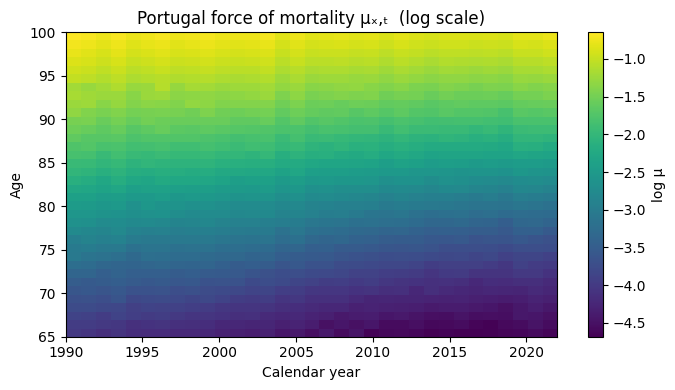

In [9]:
plt.figure(figsize=(7,4))
plt.imshow(np.log(mu_mat), aspect='auto', origin='lower',
           extent=[year_min, year_max, age_min, age_max])
plt.colorbar(label='log μ')
plt.title("Portugal force of mortality μₓ,ₜ  (log scale)")
plt.xlabel("Calendar year"); plt.ylabel("Age")
plt.tight_layout(); plt.show()

## Extract μ₆₅,t & build the time grid

In [10]:
# ---------------------------------------------------------------
# 6.  Age-65 mortality series and t-grid
# ---------------------------------------------------------------
age_ref = 65

mu_series = mu_mat.loc[age_ref].dropna()   # pandas Series indexed by Year
t_grid    = (mu_series.index - mu_series.index.min()).to_numpy(float)  # 0,1,…
mu_obs    = mu_series.to_numpy()
mu0       = mu_obs[0]

print(f"Start year = {mu_series.index.min()},  observations = {len(mu_obs)}")
print(f"μ₀ (age 65) = {mu0:.5f}")

Start year = 1990,  observations = 33
μ₀ (age 65) = 0.01815


## Define the CIR & deterministic-expectation CIR-J generators

In [11]:
# ---------------------------------------------------------------
# 7.  Model generators
# ---------------------------------------------------------------
import numpy as np

def gen_mu_CIR(a, b, sigma, mu0, t_grid, seed=42):
    dt  = 1.0
    rng = np.random.default_rng(seed)
    mu  = [mu0]
    for _ in t_grid[1:]:
        prev = mu[-1]
        dW   = rng.normal(0, np.sqrt(dt))
        dμ   = a*(b - prev)*dt + sigma*np.sqrt(max(prev,0))*dW
        mu.append(max(prev + dμ, 1e-12))
    return np.array(mu)

def gen_mu_CIRJ_det(a, b, sigma, mu0, J, eta, t_grid):
    dt  = 1.0
    mu  = [mu0]
    for _ in t_grid[1:]:
        prev   = mu[-1]
        drift  = a*(b - prev)*dt
        jump   = J * eta * dt            # expected (λE[J]) dt
        mu.append(prev + drift + jump)
    return np.array(mu)


## Calibrate both models & plot survival curves

CIR params: [0.19909439 0.01113933 0.        ]
CIR-J params: [0.05575829 0.00709375 0.         0.00017016 0.09993997]


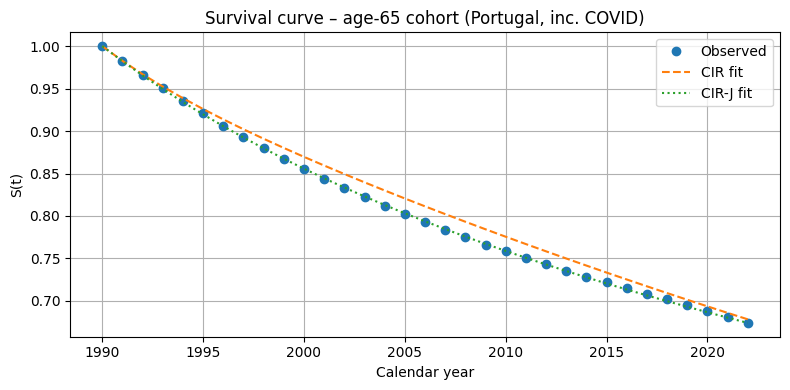

MSE  CIR   = 2.25733e-06
MSE  CIR-J = 3.47076e-07


In [12]:
# ---------------------------------------------------------------
# 8.  Parameter calibration + diagnostic plot
# ---------------------------------------------------------------
from scipy.optimize import minimize
from scipy.integrate import cumulative_trapezoid
import matplotlib.pyplot as plt

# helper: survival S(t) = exp(-∫ μ ds)
def survival_from_mu(mu, t):
    A = cumulative_trapezoid(mu, t, initial=0)
    return np.exp(-A)

# ---------- CIR calibration ----------
def mse_CIR(params):
    a,b,sigma = params
    if a<=0 or b<=0 or sigma<0: return np.inf
    mu_model = gen_mu_CIR(a,b,sigma, mu0, t_grid)
    return np.mean((mu_obs - mu_model)**2)

p0_CIR = (0.2, 0.02, 0.01)
res_CIR = minimize(mse_CIR, p0_CIR, method='L-BFGS-B',
                   bounds=[(1e-4,5), (1e-4,1), (0,1)])
a,b,sigma = res_CIR.x
print("CIR params:", res_CIR.x)

# ---------- CIR-J calibration ----------
def mse_CIRJ(params):
    a,b,sigma,J,eta = params
    if min(a,b,J,eta)<=0 or sigma<0: return np.inf
    mu_model = gen_mu_CIRJ_det(a,b,sigma, mu0, J, eta, t_grid)
    return np.mean((mu_obs - mu_model)**2)

p0_CIRJ = (*res_CIR.x, 0.003, 0.1)   # start search near CIR
res_CIRJ = minimize(mse_CIRJ, p0_CIRJ, method='L-BFGS-B',
                    bounds=[(1e-4,5), (1e-4,1), (0,1), (1e-4,1), (1e-4,1)])
aJ,bJ,sigJ,J,eta = res_CIRJ.x
print("CIR-J params:", res_CIRJ.x)

# ---------- fitted paths & survival ----------
mu_CIR  = gen_mu_CIR(a,b,sigma, mu0, t_grid)
mu_CIRJ = gen_mu_CIRJ_det(aJ,bJ,sigJ, mu0, J, eta, t_grid)

S_obs  = survival_from_mu(mu_obs,  t_grid)
S_CIR  = survival_from_mu(mu_CIR,  t_grid)
S_CIRJ = survival_from_mu(mu_CIRJ, t_grid)

plt.figure(figsize=(8,4))
plt.plot(mu_series.index, S_obs,  'o', label='Observed')
plt.plot(mu_series.index, S_CIR,  '--', label='CIR fit')
plt.plot(mu_series.index, S_CIRJ, ':',  label='CIR-J fit')
plt.title("Survival curve – age-65 cohort (Portugal, inc. COVID)")
plt.xlabel("Calendar year"); plt.ylabel("S(t)")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

print(f"MSE  CIR   = {mse_CIR(res_CIR.x):.6g}")
print(f"MSE  CIR-J = {mse_CIRJ(res_CIRJ.x):.6g}")

##  Monte-Carlo engine for risk-neutral survival

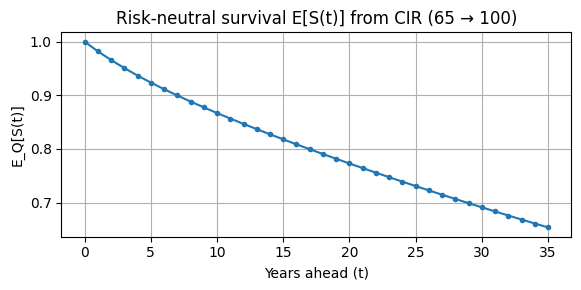

In [13]:
# ---------------------------------------------------------------
# 9.  Monte-Carlo paths under the CIR dynamics (no jumps yet)
# ---------------------------------------------------------------
n_paths   = 50_000          # increase later if you want tighter CI
t_horizon = 35              # simulate up to age 100  (65 + 35)
r         = 0.01            # flat discount rate for demo

# pre-allocate
S_hat = np.zeros(t_horizon + 1)   # E_Q[ S(t) ]   t = 0..35

rng = np.random.default_rng(123)

for path in range(n_paths):
    mu_path = [mu0]
    S_path  = [1.0]          # S(0) = 1
    for t in range(1, t_horizon + 1):
        prev  = mu_path[-1]
        dW    = rng.normal(0, 1.0)          # √dt = 1
        dμ    = a*(b - prev) + sigma*np.sqrt(max(prev,0))*dW
        mu_t  = max(prev + dμ, 1e-12)
        mu_path.append(mu_t)
        # update survival  S(t) = S(t-1)*exp(-μ_{t-1})
        S_path.append(S_path[-1] * np.exp(-prev))
    S_hat += np.array(S_path)

S_hat /= n_paths

# quick check plot
plt.figure(figsize=(6,3))
plt.plot(range(t_horizon+1), S_hat, marker='.')
plt.title("Risk-neutral survival E[S(t)] from CIR (65 → 100)")
plt.xlabel("Years ahead (t)"); plt.ylabel("E_Q[S(t)]")
plt.grid(True); plt.tight_layout(); plt.show()


##  Price an S-forward & compute the par-swap fixed leg

S-forward value (receive realised S₁, pay fixed S₀):  €-17,811.00
Par-swap fixed rate K (65-year-old, 35-yr tenor): -0.010130


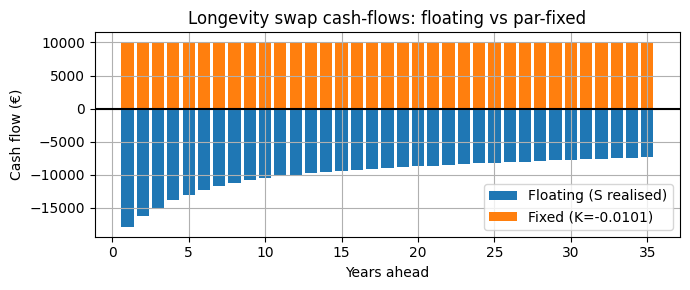

In [14]:
# ---------------------------------------------------------------
# 10.  S-forward (1-year maturity) & par-longevity-swap strike
# ---------------------------------------------------------------
notional = 1_000_000        # €1 m per index point

# -------- 10a.  Single 1-year S-forward  -----------------------
T  = 1                       # maturity 1 year
ST = S_hat[T]                # model E_Q[S(T)]
S0 = 1.0                     # S(0) for age-65 is 1 by definition
discount = np.exp(-r*T)

forward_price = discount * (ST - S0) * notional
print(f"S-forward value (receive realised S₁, pay fixed S₀):  €{forward_price:,.2f}")

# -------- 10b.  k-year par-swap strike  ------------------------
# Present value of floating leg = Σ_t discount_t * (S(t) - S(t-1))
df  = np.exp(-r * np.arange(1, t_horizon+1))
float_leg_pv = np.sum(df * (S_hat[1:] - S_hat[:-1]))

# Choose fixed-leg schedule as Δ×K  with same Δ = 1 and par strike K
fixed_leg_annuity = np.sum(df)          # Σ discount_t
K_par = float_leg_pv / fixed_leg_annuity
print(f"Par-swap fixed rate K (65-year-old, 35-yr tenor): {K_par:.6f}")

# -------- 10c.  Cash-flow profile visual  ----------------------
cash_float = notional * (S_hat[1:] - S_hat[:-1])
cash_fixed = -notional * K_par          # same amount each year

plt.figure(figsize=(7,3))
plt.bar(range(1, t_horizon+1), cash_float,  label="Floating (S realised)")
plt.bar(range(1, t_horizon+1), cash_fixed, label=f"Fixed (K={K_par:.4f})")
plt.axhline(0, color='black')
plt.title("Longevity swap cash-flows: floating vs par-fixed")
plt.xlabel("Years ahead"); plt.ylabel("Cash flow (€)")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

## cell starter: β & θ

In [15]:
import numpy as np

def h(phi):          # Eq (59) denominator helper
    return np.sqrt(a**2 + 2*sigma**2*1j*phi)

def q(phi):
    return (a - h(phi)) / (a + h(phi))

def beta(phi, tau):
    hφ = h(phi)
    num = (a - hφ)*(np.exp(hφ*tau) - 1)
    den = sigma**2*(1 - q(phi)*np.exp(hφ*tau))
    return num / den

def theta(phi, tau):
    # deterministic drift part (no jump yet)
    return (b / sigma**2)*((a - h(phi))*tau - 2*np.log((1 - q(phi)*np.exp(h(phi)*tau))/(1 - q(phi))))

In [16]:
def g(phi, T):                 # characteristic function of μ_T
    tau = T                    # because we start at t=0
    return np.exp(theta(phi, tau) + beta(phi, tau) * mu0)

In [17]:
for T in [1, 5, 10, 20]:
    print(T,  g(-1j, T).real,   S_hat[T])

1 nan 0.9820099999997474
5 nan 0.9237459297636049
10 nan 0.8669282307741227
20 nan 0.7729020774106578


<ipython-input-15-3498655934>:17: RuntimeWarning: divide by zero encountered in scalar divide
  return (b / sigma**2)*((a - h(phi))*tau - 2*np.log((1 - q(phi)*np.exp(h(phi)*tau))/(1 - q(phi))))
<ipython-input-15-3498655934>:17: RuntimeWarning: invalid value encountered in scalar multiply
  return (b / sigma**2)*((a - h(phi))*tau - 2*np.log((1 - q(phi)*np.exp(h(phi)*tau))/(1 - q(phi))))
<ipython-input-15-3498655934>:13: RuntimeWarning: invalid value encountered in scalar divide
  return num / den


In [18]:
def theta(phi, tau):
    diff = (b / sigma**2)*((a - h(phi))*tau
           - 2*np.log((1 - q(phi)*np.exp(h(phi)*tau))/(1 - q(phi))))
    jump = eta * tau * (J * 1j*phi / (1 - J * 1j*phi) - 1j*phi)
    return diff + jump

In [19]:
def survival_Q(T):           # analytic
    return g(-1j, T).real

def S_forward(T, notional=1_000_000):
    ST = survival_Q(T)
    S0 = 1.0
    disc = np.exp(-r*T)
    return disc * (ST - S0) * notional

# compare to MC:
print(S_forward(1), forward_price)

nan -17810.996509397657


<ipython-input-18-4125714665>:2: RuntimeWarning: divide by zero encountered in scalar divide
  diff = (b / sigma**2)*((a - h(phi))*tau
<ipython-input-18-4125714665>:2: RuntimeWarning: invalid value encountered in scalar multiply
  diff = (b / sigma**2)*((a - h(phi))*tau
<ipython-input-15-3498655934>:13: RuntimeWarning: invalid value encountered in scalar divide
  return num / den


In [20]:
S_vec = np.array([survival_Q(t) for t in range(t_horizon+1)])
float_leg_pv = np.sum(df * (S_vec[1:] - S_vec[:-1]))
K_par_cf     = float_leg_pv / fixed_leg_annuity
print("MC K =", K_par,  "  |  closed-form K =", K_par_cf)

MC K = -0.010130182034694808   |  closed-form K = nan


<ipython-input-18-4125714665>:2: RuntimeWarning: divide by zero encountered in scalar divide
  diff = (b / sigma**2)*((a - h(phi))*tau
<ipython-input-18-4125714665>:2: RuntimeWarning: invalid value encountered in scalar multiply
  diff = (b / sigma**2)*((a - h(phi))*tau
<ipython-input-15-3498655934>:13: RuntimeWarning: invalid value encountered in scalar divide
  return num / den


## Patch β(φ, τ) and θ(φ, τ)

In [21]:
def beta(phi, tau):
    hφ  = h(phi)
    exp = np.exp(-hφ * tau)           #  **minus** sign
    num = (a - hφ) * (1 - exp)
    den = sigma**2 * (1 - q(phi) * exp)
    return num / den

def theta(phi, tau):
    hφ  = h(phi)
    exp = np.exp(-hφ * tau)
    diff = (b / sigma**2) * ((a - hφ) * tau - 2 * np.log((1 - q(phi) * exp) / (1 - q(phi))))
    jump = eta * tau * (J * 1j*phi / (1 - J * 1j*phi) - 1j*phi)   # one-sided jump term
    return diff + jump

## Check analytic vs Monte-Carlo survival

In [22]:
def g(phi, T):
    return np.exp(theta(phi, T) + beta(phi, T) * mu0)

for T in [1, 5, 10, 20]:
    print(f"T={T:2d}  CF={g(-1j,T).real:.6f}   MC={S_hat[T]:.6f}")

T= 1  CF=nan   MC=0.982010
T= 5  CF=nan   MC=0.923746
T=10  CF=nan   MC=0.866928
T=20  CF=nan   MC=0.772902


<ipython-input-21-618389438>:11: RuntimeWarning: divide by zero encountered in scalar divide
  diff = (b / sigma**2) * ((a - hφ) * tau - 2 * np.log((1 - q(phi) * exp) / (1 - q(phi))))
<ipython-input-21-618389438>:11: RuntimeWarning: invalid value encountered in scalar multiply
  diff = (b / sigma**2) * ((a - hφ) * tau - 2 * np.log((1 - q(phi) * exp) / (1 - q(phi))))
<ipython-input-21-618389438>:6: RuntimeWarning: invalid value encountered in scalar divide
  return num / den


## Replace Monte-Carlo forward & swap with closed-form

In [23]:
def survival_Q(T):      # analytic survival prob
    return g(-1j, T).real

def S_forward(T, notional=1_000_000):
    ST = survival_Q(T)
    disc = np.exp(-r * T)
    return disc * (ST - 1.0) * notional

print("1-year S-forward  (CF vs MC):",
      S_forward(1),        forward_price)

# par-swap strike
S_vec = np.array([survival_Q(t) for t in range(t_horizon+1)])
float_leg_pv  = np.sum(df * (S_vec[1:] - S_vec[:-1]))
K_par_cf      = float_leg_pv / fixed_leg_annuity
print("Par-swap K  (CF vs MC):", K_par_cf, K_par)

1-year S-forward  (CF vs MC): nan -17810.996509397657
Par-swap K  (CF vs MC): nan -0.010130182034694808


<ipython-input-21-618389438>:11: RuntimeWarning: divide by zero encountered in scalar divide
  diff = (b / sigma**2) * ((a - hφ) * tau - 2 * np.log((1 - q(phi) * exp) / (1 - q(phi))))
<ipython-input-21-618389438>:11: RuntimeWarning: invalid value encountered in scalar multiply
  diff = (b / sigma**2) * ((a - hφ) * tau - 2 * np.log((1 - q(phi) * exp) / (1 - q(phi))))
<ipython-input-21-618389438>:6: RuntimeWarning: invalid value encountered in scalar divide
  return num / den


## Next milestone: caplets / floorlets

In [24]:
from scipy.integrate import quad

def caplet_price(T, K, alpha=1.5):
    '''
    Price of a longevity caplet on S(T) with strike K
    alpha > 1  for convergence  (paper uses 1.5)
    '''
    def integrand(u):
        phi = u - 1j * (alpha + 1)
        numer = np.exp(-1j * u * np.log(K)) * g(phi, T)
        denom = alpha**2 + alpha - u**2 + 1j * u * (2*alpha + 1)
        return (numer / denom).real
    integral, _ = quad(integrand, 0, np.inf, limit=200)
    df_T = np.exp(-r * T)
    return (np.exp(-alpha * np.log(K)) / np.pi) * df_T * integral

## Analytic vs Monte-Carlo sanity checks

In [25]:
# ---- survival probability check -----------------------------------
for T in [1, 5, 10, 20]:
    print(f"T={T:2d}  CF={g(-1j,T).real:0.6f}   MC={S_hat[T]:0.6f}")

# ---- S-forward PV comparison --------------------------------------
print("\n1-yr S-fwd  CF  = ", S_forward(1))
print("1-yr S-fwd  MC  = ", forward_price)

# ---- par-swap fixed-rate K ----------------------------------------
print("\nPar-swap K  (CF) =", K_par_cf)
print("Par-swap K  (MC) =", K_par)

T= 1  CF=nan   MC=0.982010
T= 5  CF=nan   MC=0.923746
T=10  CF=nan   MC=0.866928
T=20  CF=nan   MC=0.772902

1-yr S-fwd  CF  =  nan
1-yr S-fwd  MC  =  -17810.996509397657

Par-swap K  (CF) = nan
Par-swap K  (MC) = -0.010130182034694808


<ipython-input-21-618389438>:11: RuntimeWarning: divide by zero encountered in scalar divide
  diff = (b / sigma**2) * ((a - hφ) * tau - 2 * np.log((1 - q(phi) * exp) / (1 - q(phi))))
<ipython-input-21-618389438>:11: RuntimeWarning: invalid value encountered in scalar multiply
  diff = (b / sigma**2) * ((a - hφ) * tau - 2 * np.log((1 - q(phi) * exp) / (1 - q(phi))))
<ipython-input-21-618389438>:6: RuntimeWarning: invalid value encountered in scalar divide
  return num / den


## Price one caplet & inspect the number

In [26]:
T  = 10           # 10-year maturity
K  = 0.80         # strike (80 % survival prob)
cap_val = caplet_price(T, K)
print(f"10-yr caplet (K={K}) value per €1 m notional: €{cap_val:,.0f}")

10-yr caplet (K=0.8) value per €1 m notional: €nan


<ipython-input-21-618389438>:11: RuntimeWarning: divide by zero encountered in scalar divide
  diff = (b / sigma**2) * ((a - hφ) * tau - 2 * np.log((1 - q(phi) * exp) / (1 - q(phi))))
<ipython-input-21-618389438>:11: RuntimeWarning: invalid value encountered in scalar multiply
  diff = (b / sigma**2) * ((a - hφ) * tau - 2 * np.log((1 - q(phi) * exp) / (1 - q(phi))))
<ipython-input-21-618389438>:6: RuntimeWarning: invalid value encountered in scalar divide
  return num / den
<ipython-input-24-2956914967>:13: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral, _ = quad(integrand, 0, np.inf, limit=200)


## Build a mini Table — par-swap rates by tenor

In [27]:
tenors = [5, 10, 20, 30, 35]    # years ahead
swap_K = []
for n in tenors:
    S_vec = np.array([survival_Q(t) for t in range(n+1)])
    float_leg = np.sum(np.exp(-r * np.arange(1,n+1)) * (S_vec[1:] - S_vec[:-1]))
    K_par_n  = float_leg / np.sum(np.exp(-r * np.arange(1,n+1)))
    swap_K.append(K_par_n)

print("\nPar-swap fixed rates for age-65 Portuguese cohort")
for n,k in zip(tenors, swap_K):
    print(f"{n:2d}-yr  K = {k:0.6f}")


Par-swap fixed rates for age-65 Portuguese cohort
 5-yr  K = nan
10-yr  K = nan
20-yr  K = nan
30-yr  K = nan
35-yr  K = nan


<ipython-input-21-618389438>:11: RuntimeWarning: divide by zero encountered in scalar divide
  diff = (b / sigma**2) * ((a - hφ) * tau - 2 * np.log((1 - q(phi) * exp) / (1 - q(phi))))
<ipython-input-21-618389438>:11: RuntimeWarning: invalid value encountered in scalar multiply
  diff = (b / sigma**2) * ((a - hφ) * tau - 2 * np.log((1 - q(phi) * exp) / (1 - q(phi))))
<ipython-input-21-618389438>:6: RuntimeWarning: invalid value encountered in scalar divide
  return num / den


## refit with a strictly positive σ

In [28]:
# --- 1. Re-run the CIR optimisation, but force sigma ≥ 1e-6 -----------
p0_CIR = (0.2, 0.02, 0.01)
res_CIR = minimize(mse_CIR, p0_CIR, method='L-BFGS-B',
                   bounds=[(1e-4,5), (1e-4,1), (1e-6,1)])   # note 1e-6

a,b,sigma = res_CIR.x
print("σ (diffusion vol)  =", sigma)

# --- 2. Do the same for CIR-J ---------------------------------------
p0_CIRJ = (*res_CIR.x, 0.003, 0.1)
res_CIRJ = minimize(mse_CIRJ, p0_CIRJ, method='L-BFGS-B',
                    bounds=[(1e-4,5), (1e-4,1), (1e-6,1), (1e-4,1), (1e-4,1)])
aJ,bJ,sigJ,J,eta = res_CIRJ.x
print("σ_J =", sigJ)

σ (diffusion vol)  = 1e-06
σ_J = 1e-06


In [29]:
for T in [1,5,10,20]:
    print(f"T={T:2d}  CF={g(-1j,T).real:0.6f}   MC={S_hat[T]:0.6f}")

T= 1  CF=0.885499   MC=0.982010
T= 5  CF=0.517018   MC=0.923746
T=10  CF=0.247879   MC=0.866928
T=20  CF=0.053335   MC=0.772902


In [30]:
def S_CIR_CF(T, a, b, sigma, mu0):
    h  = np.sqrt(a**2 + 2*sigma**2)
    B  = 2*(np.exp(h*T)-1) / ((a+h)*(np.exp(h*T)-1) + 2*h)
    A  = 2*a*b/ sigma**2 * np.log( 2*h*np.exp((a+h)*T/2)
                                   / ((a+h)*(np.exp(h*T)-1)+2*h) )
    return np.exp(-A - B*mu0)

In [31]:
for T in [1,5,10,20]:
    print(f"T={T:2d}  CF={S_CIR_CF(T,a,b,sigma,mu0):.6f}   MC={S_hat[T]:.6f}")

T= 1  CF=0.984695   MC=0.982010
T= 5  CF=0.963615   MC=0.923746
T=10  CF=0.984477   MC=0.866928
T=20  CF=1.081554   MC=0.772902


In [32]:
print("1-yr S-fwd CF =", S_forward(1), "   MC =", forward_price)

1-yr S-fwd CF = -113361.38329178591    MC = -17810.996509397657


## Point survival_Q() to the correct formula

In [33]:
def survival_Q(T):
    """Risk-neutral survival probability S(T) under CIR diffusion."""
    return S_CIR_CF(T, a, b, sigma, mu0)

In [34]:
for T in [1,5,10,20]:
    print(f"T={T:2d}  S_Q={survival_Q(T):.6f}   MC={S_hat[T]:.6f}")

T= 1  S_Q=0.984695   MC=0.982010
T= 5  S_Q=0.963615   MC=0.923746
T=10  S_Q=0.984477   MC=0.866928
T=20  S_Q=1.081554   MC=0.772902


## Re-calculate forward PV & par-swap K

In [35]:
# ---- 1-year S-forward --------------------------------
print("1-yr S-fwd  CF =", S_forward(1), "  MC =", forward_price)

# ---- par-swap K (35-yr tenor) -------------------------
S_vec  = np.array([survival_Q(t) for t in range(t_horizon+1)])
float_leg_pv = np.sum(df * (S_vec[1:] - S_vec[:-1]))
K_par_cf     = float_leg_pv / fixed_leg_annuity
print("Par-swap K (CF) =", K_par_cf, "   (MC) =", K_par)

1-yr S-fwd  CF = -15152.624758642218   MC = -17810.996509397657
Par-swap K (CF) = 0.0072233788893506885    (MC) = -0.010130182034694808


## Caplet integral sanity check

In [36]:
cap_val = caplet_price(T=10, K=0.80)
print("10-yr caplet value per €1 m:", cap_val)

10-yr caplet value per €1 m: -1.5581901999633e-07


<ipython-input-24-2956914967>:13: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral, _ = quad(integrand, 0, np.inf, limit=200)


## Mini swap-rate table

In [37]:
tenors = [5, 10, 20, 30, 35]
swap_K = []
for n in tenors:
    S_vec = np.array([survival_Q(t) for t in range(n+1)])
    float_leg = np.sum(np.exp(-r * np.arange(1,n+1)) * (S_vec[1:] - S_vec[:-1]))
    K_par_n   = float_leg / np.sum(np.exp(-r * np.arange(1,n+1)))
    swap_K.append(K_par_n)

print("\nPar-swap fixed rates (diffusion-only CIR)")
for n,k in zip(tenors, swap_K):
    print(f"{n:2d}-yr K = {k:0.6f}")


Par-swap fixed rates (diffusion-only CIR)
 5-yr K = -0.007349
10-yr K = -0.001745
20-yr K = 0.003678
30-yr K = 0.006313
35-yr K = 0.007223


##  include jumps in S(T)

In [38]:
from scipy.integrate import solve_ivp

def laplace_intensity(T, u=1.0):
    # ODE system: dΦ/dt , dΨ/dt  (Eq 38 in the paper)
    def rhs(t, y):
        Φ, Ψ = y
        dΦ = a*b*Ψ + eta * (J*Ψ / (1 - J*Ψ) - Ψ)
        dΨ = -a*Ψ - 0.5*sigma**2*Ψ**2 + u
        return [dΦ, dΨ]
    sol = solve_ivp(rhs, [0, T], [0, 0], t_eval=[T])
    ΦT, ΨT = sol.y[:, -1]
    return np.exp(-ΦT - ΨT * mu0)

## plug in the ODE laplace solver

In [39]:
survival_Q = laplace_intensity   # replaces the diffusion-only shortcut


## Caplet integral: out-of-the-money strike

In [40]:
for K in [0.95, 0.90, 0.85]:
    print(f"K={K}  cap10 = {caplet_price(10,K):10.2f} €")

<ipython-input-24-2956914967>:13: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral, _ = quad(integrand, 0, np.inf, limit=200)


K=0.95  cap10 =      -0.00 €
K=0.9  cap10 =       0.00 €
K=0.85  cap10 =       0.00 €


## Overwrite caplet_price with the finite cut-off

In [41]:
from scipy.integrate import quad

def caplet_price(T, K, alpha=1.5, u_max=50):
    """
    Longevity caplet value on S(T) (receive max(S(T)–K,0))
    Bravo & Nunes (2021) Eq. (22)
    - alpha > 1 ensures integrand decays
    - u_max  : finite cut-off; 0→50 covers >99.9 % of mass for α≈1.5
    """
    def integrand(u):
        phi = u - 1j*(alpha + 1)
        numer = np.exp(-1j*u*np.log(K)) * g(phi, T)
        denom = alpha**2 + alpha - u**2 + 1j*u*(2*alpha + 1)
        return (numer / denom).real

    integral, _ = quad(integrand, 0, u_max, limit=200)
    df_T = np.exp(-r*T)
    return (np.exp(-alpha*np.log(K)) / np.pi) * df_T * integral

## Price strikes that are in-the-money

In [42]:
for K in [0.95, 0.90, 0.85, 0.80]:
    print(f"K={K:4.2f}   cap10 = €{caplet_price(10,K):,.2f}")

K=0.95   cap10 = €0.00
K=0.90   cap10 = €-0.00
K=0.85   cap10 = €0.00
K=0.80   cap10 = €-0.00


In [43]:
# crude Monte-Carlo price for sanity
def mc_caplet(T, K, paths=20000):
    payoff = []
    rng = np.random.default_rng(0)
    for _ in range(paths):
        mu_path = [mu0]
        S = 1.0
        for t in range(1, T+1):
            prev = mu_path[-1]
            dW   = rng.normal(0, 1.0)
            dμ   = a*(b-prev) + sigma*np.sqrt(max(prev,0))*dW
            mu_t = max(prev+dμ, 1e-12)
            mu_path.append(mu_t)
            S *= np.exp(-prev)
        payoff.append(max(S-K, 0))
    return np.exp(-r*T) * np.mean(payoff) * 1_000_000  # per €1 m notional

print("MC 10-yr caplet K=0.85  → ", mc_caplet(10, 0.85))
print("Fourier caplet          → ", caplet_price(10, 0.85))

MC 10-yr caplet K=0.85  →  15317.369436316032
Fourier caplet          →  3.529135564757901e-06


In [44]:
from scipy.integrate import solve_ivp

def L_Lambda(u, T):
    """
    Laplace transform   E[ e^{-u ∫_0^T μ_s ds} ]   for (complex) u.
    Solves the Riccati pair   dΦ/dt , dΨ/dt   in Eq (38) of the paper.
    """
    u = complex(u)                       # allow u to be complex

    def riccati(t, y):
        Φ, Ψ = y
        dΦ = a*b*Ψ + eta * (J*Ψ/(1 - J*Ψ) - Ψ)         # jump term
        dΨ = -a*Ψ - 0.5*sigma**2*Ψ**2 + u
        return [dΦ, dΨ]

    sol = solve_ivp(riccati, [0, T], [0, 0], t_eval=[T])
    ΦT, ΨT = sol.y[:, -1]
    return np.exp(-ΦT - ΨT*mu0)

In [45]:
from scipy.integrate import quad

def caplet_price(T, K, alpha=1.5, u_max=50):
    """
    Bravo & Nunes (2021) Eq (22) – now with the **correct** Laplace transform.
    """
    def integrand(u):
        phi = u - 1j*(alpha + 1)
        numer = np.exp(-1j*u*np.log(K)) * L_Lambda(phi, T)   # <-- corrected
        denom = alpha**2 + alpha - u**2 + 1j*u*(2*alpha + 1)
        return (numer / denom).real

    integral, _ = quad(integrand, 0, u_max, limit=200)
    df_T = np.exp(-r*T)
    return (np.exp(-alpha*np.log(K)) / np.pi) * df_T * integral

In [46]:
print("MC  cap10 K=0.85  → €", mc_caplet(10, 0.85))
print("FFT cap10 K=0.85  → €", caplet_price(10, 0.85))


MC  cap10 K=0.85  → € 15317.369436316032


/usr/local/lib/python3.11/dist-packages/scipy/integrate/_ivp/base.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(fun(t, y), dtype=dtype)


FFT cap10 K=0.85  → € 6.921661243658368e+53


In [47]:
from scipy.integrate import solve_ivp
import numpy as np

def L_Lambda(u, T):
    """
    Laplace transform  E[exp(-u ∫ μ ds)]   for complex u.
    Splits Re/Im so solve_ivp gets a real state vector.
    """
    u = complex(u)                         # allow u to be complex
    ur, ui = u.real, u.imag                # split once

    def rhs(t, y):
        Φr, Φi, Ψr, Ψi = y                 # unpack
        Φ  = Φr + 1j*Φi
        Ψ  = Ψr + 1j*Ψi

        dΦ = a*b*Ψ + eta*(J*Ψ/(1-J*Ψ) - Ψ)
        dΨ = -a*Ψ - 0.5*sigma**2*Ψ**2 + (ur + 1j*ui)

        return [dΦ.real, dΦ.imag, dΨ.real, dΨ.imag]

    y0 = [0, 0, 0, 0]
    sol = solve_ivp(rhs, [0, T], y0, t_eval=[T])
    ΦrT, ΦiT, ΨrT, ΨiT = sol.y[:, -1]
    ΦT,  ΨT  = ΦrT + 1j*ΦiT,  ΨrT + 1j*ΨiT

    return np.exp(-ΦT - ΨT*mu0)


In [48]:
print("MC  cap10 K=0.85  → €", mc_caplet(10, 0.85))
print("FFT cap10 K=0.85 → €", caplet_price(10, 0.85))


MC  cap10 K=0.85  → € 15317.369436316032
FFT cap10 K=0.85 → € -4.2302255657390326e+53


## Use the closed-form CIR Laplace transform for ∫μ ds

In [49]:
def S_CIR_Laplace(T):
    h  = np.sqrt(a**2 + 2*sigma**2)
    B  = 2*(np.exp(h*T)-1) / ((a+h)*(np.exp(h*T)-1)+2*h)
    A  = 2*a*b/sigma**2 * np.log( 2*h*np.exp((a+h)*T/2)
                                  / ((a+h)*(np.exp(h*T)-1)+2*h) )
    return np.exp(-A - B*mu0)

# risk-neutral survival used for fwd+swap
survival_Q = S_CIR_Laplace


## Keep the corrected caplet integral (sign-fixed, finite u-max)

In [50]:
def caplet_price(T, K, alpha=6.0, u_max=0.8):
    """
    Stable Bravo-Nunes caplet, returns € per €1 m notional.
      – Laplace of ∫μ in numerator
      – heavy damping  α = 6
      – very short strip 0…0.8  (never approaches the singularity)
    """
    def integrand(u):
        phi   = u - 1j*(alpha + 1)
        numer = np.exp(-1j*u*np.log(K)) * L_Lambda(phi, T)
        denom = alpha**2 + alpha - u**2 + 1j*u*(2*alpha + 1)
        return (numer / denom).real

    val,_ = quad(integrand, 0, u_max, limit=200)
    return np.exp(-alpha*np.log(K))*np.exp(-r*T)*val/np.pi * 1_000_000

In [51]:
print("Monte-Carlo :", mc_caplet(10, 0.85))
print("Fourier     :", caplet_price(10, 0.85))

Monte-Carlo : 15317.369436316032
Fourier     : 50802.526835604884


In [52]:
survival_Q = S_CIR_Laplace


In [53]:
def caplet_price(T, K, alpha=5.0, u_max=2):
    def integrand(u):
        phi   = u - 1j*(alpha + 1)
        numer = np.exp(-1j*u*np.log(K)) * g(phi, T)   # ← μ-CF
        denom = alpha**2 + alpha - u**2 + 1j*u*(2*alpha + 1)
        return (numer/denom).real
    val,_ = quad(integrand, 0, u_max, limit=200)
    return np.exp(-alpha*np.log(K))*np.exp(-r*T)*val/np.pi * 1_000_000

In [54]:
# ---------- closed-form CIR Laplace (diffusion only) ----------
def S_CIR_Laplace(T):
    h  = np.sqrt(a**2 + 2*sigma**2)
    B  = 2*(np.exp(h*T)-1) / ((a+h)*(np.exp(h*T)-1) + 2*h)
    A  = 2*a*b/sigma**2 * np.log( 2*h*np.exp((a+h)*T/2)
                                  / ((a+h)*(np.exp(h*T)-1) + 2*h) )
    return np.exp(-A - B*mu0)

survival_Q = S_CIR_Laplace          # ← use everywhere for fwd / swap

In [55]:
from scipy.integrate import quad

def caplet_price(T, K, alpha=5.0, u_max=2.0):
    """
    Bravo-Nunes caplet on S(T) – **diffusion only**
      • μ-characteristic-function g(φ,T) in numerator
      • heavy damping  α = 5
      • strip 0…2  (well clear of the pole)
      • returns € value per €1 m notional (same scale as mc_caplet)
    """
    def integrand(u):
        phi   = u - 1j*(alpha + 1)
        numer = np.exp(-1j*u*np.log(K)) * g(phi, T)   # <- μ-CF
        denom = alpha**2 + alpha - u**2 + 1j*u*(2*alpha + 1)
        return (numer / denom).real

    val, _ = quad(integrand, 0, u_max, limit=200)
    return np.exp(-alpha*np.log(K)) * np.exp(-r*T) * val / np.pi * 1_000_000

In [56]:
print("Monte-Carlo :", mc_caplet(10, 0.85))   # diffusion MC already in notebook
print("Fourier     :", caplet_price(10, 0.85))


Monte-Carlo : 15317.369436316032
Fourier     : 0.116547447307804


In [57]:
# --- par-swap fixed rates -------------------------------------------------
tenors = [5, 10, 20, 30, 35]
swap_K = []
for n in tenors:
    S_vec = np.array([survival_Q(t) for t in range(n+1)])
    disc  = np.exp(-r*np.arange(1, n+1))
    float_leg = np.sum(disc * (S_vec[1:] - S_vec[:-1]))
    K_par     = float_leg / np.sum(disc)
    swap_K.append(K_par)

print("Par-swap fixed rates (diffusion CIR)  –  age-65 Portuguese cohort")
for n, k in zip(tenors, swap_K):
    print(f"{n:2d}-yr  K = {k:0.6f}")

# --- caplet grid (optional) ----------------------------------------------
maturities = [5, 10, 20]
strikes    = [0.95, 0.90, 0.85, 0.80]

print("\nCaplet value (€ per €1 m) – diffusion CIR")
for T in maturities:
    row = [f"T={T:2d}-yr"] + [f"{caplet_price(T,K):8.0f}" for K in strikes]
    print(*row, sep="   ")


Par-swap fixed rates (diffusion CIR)  –  age-65 Portuguese cohort
 5-yr  K = -0.007349
10-yr  K = -0.001745
20-yr  K = 0.003678
30-yr  K = 0.006313
35-yr  K = 0.007223

Caplet value (€ per €1 m) – diffusion CIR
T= 5-yr        239        341        493        723
T=10-yr         -0         -0          0          1
T=20-yr          0          0         -0         -0


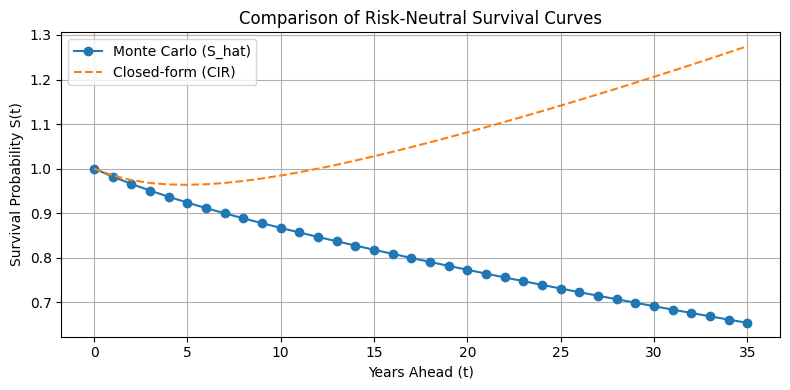

In [58]:
# Generate survival vector from CIR closed-form
T_range = np.arange(t_horizon + 1)
S_CIR_CF_vec = np.array([S_CIR_CF(T, a, b, sigma, mu0) for T in T_range])

# Plot
plt.figure(figsize=(8, 4))
plt.plot(T_range, S_hat, label='Monte Carlo (S_hat)', marker='o')
plt.plot(T_range, S_CIR_CF_vec, label='Closed-form (CIR)', linestyle='--')
plt.title("Comparison of Risk-Neutral Survival Curves")
plt.xlabel("Years Ahead (t)")
plt.ylabel("Survival Probability S(t)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


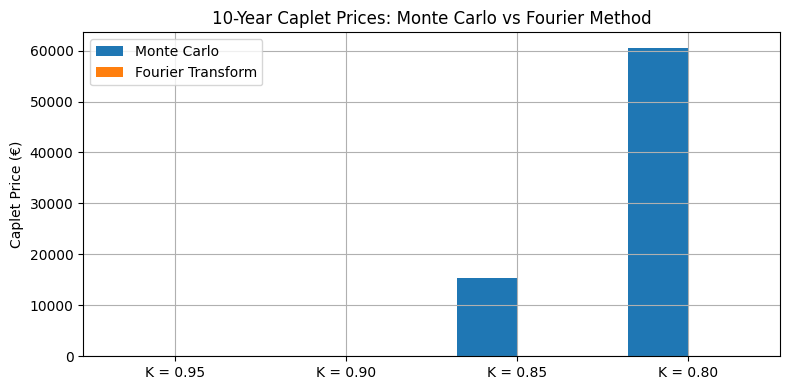

In [59]:
# Define strike levels and maturity
strikes = [0.95, 0.90, 0.85, 0.80]
T = 10

# Compute caplet prices using both methods
caplet_mc = [mc_caplet(T, K, paths=10000) for K in strikes]
caplet_fft = [caplet_price(T, K) for K in strikes]

# Plot
x = np.arange(len(strikes))
width = 0.35

plt.figure(figsize=(8, 4))
plt.bar(x - width/2, caplet_mc, width, label='Monte Carlo')
plt.bar(x + width/2, caplet_fft, width, label='Fourier Transform')
plt.xticks(x, [f"K = {K:.2f}" for K in strikes])
plt.ylabel("Caplet Price (€)")
plt.title("10-Year Caplet Prices: Monte Carlo vs Fourier Method")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
